# Lab 1
Aim: To do Linear regression on some publicly available dataset \
Objective: Import necessary libraries (scikit-learn, numpy, pandas, matplotlib). Load a dataset suitable for supervised learning. Split the dataset into training and testing sets and feature engineering techniques.

## Download Data

In [7]:
import kagglehub
import pandas as pd
import os

def download_data():
    if os.path.exists('data.csv'):
        print("Using existing data.csv...")
        return pd.read_csv('data.csv')
    print("Downloading dataset using kagglehub...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-202-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                import shutil
                shutil.cpy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("data.csv ready.")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after kagglehub download.")

df = download_data()

Using existing data.csv...


Dataset downloaded successfully!

Feature Statistics:
                           mean         median            std      skew  \
acousticness           0.502115       0.516000       0.376032 -0.032582   
danceability           0.537396       0.548000       0.176138 -0.223469   
duration_ms       230948.310666  207467.000000  126118.414668  7.313676   
energy                 0.482389       0.471000       0.267646  0.112034   
instrumentalness       0.167010       0.000216       0.313475  1.631100   
key                    5.199844       5.000000       3.515094  0.005864   
liveness               0.205839       0.136000       0.174805  2.154363   
loudness             -11.467990     -10.580000       5.697943 -1.051832   
mode                   0.706902       1.000000       0.455184 -0.909095   
speechiness            0.098393       0.045000       0.162740  4.047813   
tempo                116.861590     114.729000      30.708533  0.449737   
valence                0.528587       0.540000

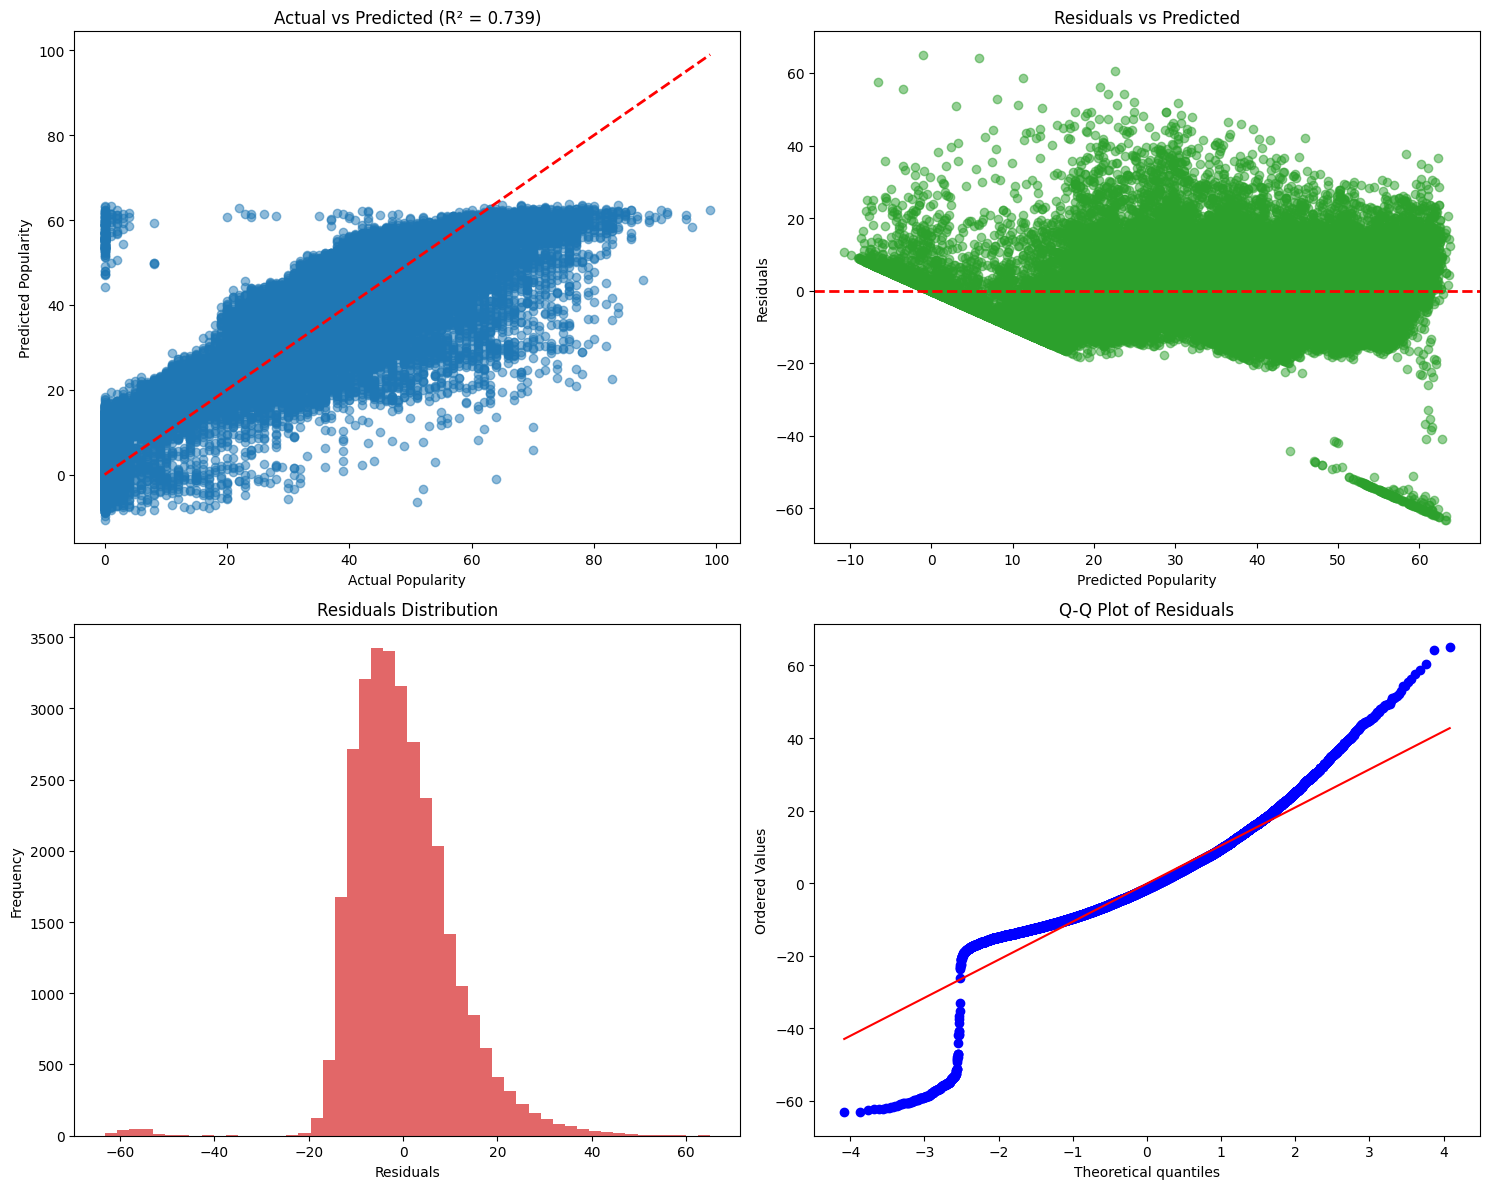

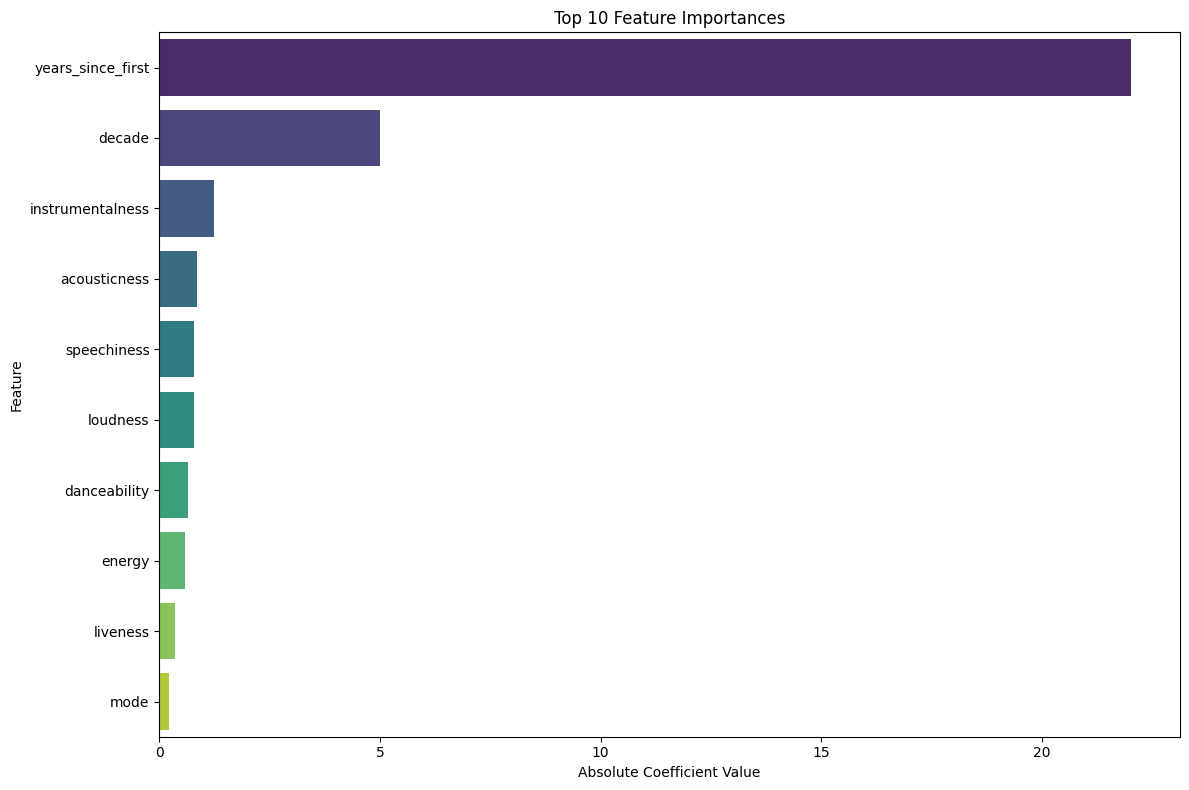

Model saved as spotify_model.joblib


In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, MinMaxScaler,
    PowerTransformer, QuantileTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from scipy import stats
from scipy.stats import skew, kurtosis, probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib
import warnings
import kagglehub

warnings.filterwarnings('ignore')

class SpotifyPopularityPredictor:
    def __init__(self):
        # Feature lists
        self.initial_numeric_features = [
            'acousticness', 'danceability', 'duration_ms', 'energy',
            'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'valence', 'year'
        ]
        self.numeric_features = []  # To be updated after transformations
        self.pipeline_features = []  # Final features used in pipeline
        
        # Models and transformers
        self.best_model = None
        self.feature_importance = None
        self.pca_transformer = None
        self.vif_scaler = None
        self.feature_transformations = {}
        
    def download_data(self):
        """Download dataset using kagglehub."""
        print("Downloading dataset...")
        path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
        if not os.path.exists('data.csv'):
            for root, dirs, files in os.walk(path):
                if 'data.csv' in files:
                    import shutil
                    shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                    break
        if os.path.exists('data.csv'):
            print("Dataset downloaded successfully!")
            return pd.read_csv('data.csv')
        else:
            raise FileNotFoundError("data.csv not found after download.")
    
    def analyze_data(self, df):
        """Perform comprehensive statistical analysis."""
        stats_dict = {}
        for col in self.initial_numeric_features:
            stats_dict[col] = {
                'mean': df[col].mean(),
                'median': df[col].median(),
                'std': df[col].std(),
                'skew': skew(df[col].dropna()),
                'kurtosis': kurtosis(df[col].dropna()),
                'missing': df[col].isnull().sum(),
                'missing_pct': (df[col].isnull().sum() / len(df)) * 100,
                'unique': df[col].nunique(),
                'iqr': df[col].quantile(0.75) - df[col].quantile(0.25)
            }
        
        # Correlation analysis
        correlation_matrix = df[self.initial_numeric_features].corr()
        
        return pd.DataFrame(stats_dict).T, correlation_matrix
    
    def normalize_year_feature(self, df):
        """
        Normalize year feature to reduce its impact and create related features.
        """
        df = df.copy()
        min_year = df['year'].min()
        max_year = df['year'].max()
        
        # Convert to relative years since first release
        df['years_since_first'] = (df['year'] - min_year) / (max_year - min_year)
        
        # Add decade feature
        df['decade'] = ((df['year'] - min_year) // 10) * 10 / (max_year - min_year)
        
        # Remove original year column
        df = df.drop('year', axis=1)
        
        return df
    
    def handle_multicollinearity_advanced(self, X, threshold=5, max_iterations=10):
        """
        Reduce multicollinearity using VIF with proper feature handling.
        """
        X = X.copy()
        
        # Normalize year feature first
        if 'year' in X.columns:
            X = self.normalize_year_feature(X)
        
        def calculate_vif(X_df):
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_df.columns
            vif_data["VIF"] = [
                variance_inflation_factor(X_df.values, i) 
                for i in range(X_df.shape[1])
            ]
            return vif_data.sort_values('VIF', ascending=False)
        
        def reduce_collinearity_iterative(X_df, threshold, max_iter):
            """Iteratively reduce collinearity using multiple techniques."""
            X_processed = X_df.copy()
            transformations = {}
            iteration = 0
            
            while iteration < max_iter:
                vif = calculate_vif(X_processed)
                max_vif = vif['VIF'].max()
                
                if max_vif <= threshold:
                    break
                
                print(f"\nIteration {iteration + 1}:")
                print(f"Max VIF: {max_vif:.2f}")
                
                # Identify the feature with the highest VIF
                problem_feature = vif.iloc[0]['Feature']
                print(f"High VIF feature detected: {problem_feature}")
                
                # Attempt various transformations
                transformed = False
                
                # 1. Log Transformation
                if (X_processed[problem_feature] > 0).all():
                    try:
                        X_temp = X_processed.copy()
                        X_temp[problem_feature] = np.log1p(X_temp[problem_feature])
                        new_vif = calculate_vif(X_temp)['VIF'].max()
                        if new_vif < max_vif:
                            X_processed = X_temp
                            transformations[problem_feature] = 'log'
                            print(f"Applied log transformation to {problem_feature}. New max VIF: {new_vif:.2f}")
                            transformed = True
                    except:
                        pass
                
                # 2. Square Root Transformation
                if not transformed and (X_processed[problem_feature] >= 0).all():
                    try:
                        X_temp = X_processed.copy()
                        X_temp[problem_feature] = np.sqrt(X_temp[problem_feature] - 
                                                         X_temp[problem_feature].min() + 1e-6)
                        new_vif = calculate_vif(X_temp)['VIF'].max()
                        if new_vif < max_vif:
                            X_processed = X_temp
                            transformations[problem_feature] = 'sqrt'
                            print(f"Applied square root transformation to {problem_feature}. New max VIF: {new_vif:.2f}")
                            transformed = True
                    except:
                        pass
                
                # 3. Box-Cox Transformation
                if not transformed and (X_processed[problem_feature] > 0).all():
                    try:
                        X_temp = X_processed.copy()
                        X_temp[problem_feature], lambda_param = stats.boxcox(X_temp[problem_feature])
                        new_vif = calculate_vif(X_temp)['VIF'].max()
                        if new_vif < max_vif:
                            X_processed = X_temp
                            transformations[problem_feature] = ('box-cox', lambda_param)
                            print(f"Applied Box-Cox transformation to {problem_feature}. New max VIF: {new_vif:.2f}")
                            transformed = True
                    except:
                        pass
                
                # 4. Yeo-Johnson Transformation
                if not transformed:
                    try:
                        pt = PowerTransformer(method='yeo-johnson')
                        X_temp = X_processed.copy()
                        X_temp[problem_feature] = pt.fit_transform(X_temp[[problem_feature]]).ravel()
                        new_vif = calculate_vif(X_temp)['VIF'].max()
                        if new_vif < max_vif:
                            X_processed = X_temp
                            transformations[problem_feature] = 'yeo-johnson'
                            print(f"Applied Yeo-Johnson transformation to {problem_feature}. New max VIF: {new_vif:.2f}")
                            transformed = True
                    except:
                        pass
                
                # 5. Remove Feature if no transformation helps
                if not transformed:
                    print(f"Could not reduce VIF for {problem_feature}. Removing it from the dataset.")
                    X_processed = X_processed.drop(columns=[problem_feature])
                    transformations[problem_feature] = 'removed'
                
                iteration += 1
            
            return X_processed, transformations
        
        print("\nInitial VIF Analysis:")
        initial_vif = calculate_vif(X)
        print(initial_vif)
        
        # Apply iterative collinearity reduction
        X_processed, transformations = reduce_collinearity_iterative(X, threshold, max_iterations)
        
        print("\nFinal VIF Analysis:")
        final_vif = calculate_vif(X_processed)
        print(final_vif)
        
        # Store transformations
        self.feature_transformations = transformations
        
        return X_processed
    
    def detect_outliers(self, X, y, method='zscore', threshold=3):
        """Detect and remove outliers using specified method."""
        if method == 'zscore':
            z_scores = np.abs(stats.zscore(X.select_dtypes(include=[np.number])))
            mask = (z_scores < threshold).all(axis=1)
        elif method == 'iqr':
            Q1 = X.quantile(0.25)
            Q3 = X.quantile(0.75)
            IQR = Q3 - Q1
            mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
        elif method == 'isolation_forest':
            iso_forest = IsolationForest(contamination=0.1, random_state=42)
            mask = iso_forest.fit_predict(X) == 1
        else:
            raise ValueError("Unsupported outlier detection method.")
        
        print(f"\nOutlier Detection using {method}:")
        print(f"Original samples: {len(y)}, After removal: {mask.sum()}")
        return X[mask], y[mask]
    
    def create_preprocessing_pipeline(self):
        """Create preprocessing pipeline with multiple options."""
        numeric_transformer = Pipeline(steps=[
            ('imputer', KNNImputer(n_neighbors=5)),
            ('scaler', StandardScaler()),
            ('power', PowerTransformer(method='yeo-johnson'))
        ])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, self.pipeline_features)
            ]
        )
        
        return preprocessor
    
    def create_model_pipeline(self, preprocessor):
        """Create full pipeline including preprocessing and model."""
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
            ('regressor', Ridge())
        ])
        
        # Define parameter grid for GridSearchCV
        param_grid = {
            'preprocessor__num__imputer': [SimpleImputer(strategy='mean'), KNNImputer(n_neighbors=5)],
            'preprocessor__num__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
            'preprocessor__num__power': [PowerTransformer(method='yeo-johnson'),
                                         QuantileTransformer(output_distribution='normal')],
            'feature_selection__k': [5, 8, 10, 'all'],
            'regressor': [Ridge(), Lasso(), ElasticNet()],
            'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
        }
        
        return pipeline, param_grid
    
    def train_model(self, X, y):
        """Train model with GridSearchCV."""
        preprocessor = self.create_preprocessing_pipeline()
        pipeline, param_grid = self.create_model_pipeline(preprocessor)
        
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )
        
        print("\nStarting GridSearchCV...")
        grid_search.fit(X, y)
        
        self.best_model = grid_search
        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best cross-validation R² score: {grid_search.best_score_:.4f}")
        
        # Feature importance (only for linear models)
        if hasattr(grid_search.best_estimator_.named_steps['regressor'], 'coef_'):
            coefs = grid_search.best_estimator_.named_steps['regressor'].coef_
            self.feature_importance = pd.DataFrame({
                'feature': self.pipeline_features,
                'importance': np.abs(coefs)
            }).sort_values('importance', ascending=False)
        
        return grid_search
    
    def evaluate_model(self, model, X_test, y_test):
        """Evaluate model performance."""
        y_pred = model.predict(X_test)
        metrics = {
            'r2': r2_score(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'mae': mean_absolute_error(y_test, y_pred)
        }
        return metrics, y_pred
    
    def plot_diagnostics(self, y_test, y_pred, metrics):
        """Plot comprehensive model diagnostics."""
        residuals = y_test - y_pred
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Actual vs Predicted
        ax1.scatter(y_test, y_pred, alpha=0.5, color='#1f77b4')
        ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        ax1.set_xlabel('Actual Popularity')
        ax1.set_ylabel('Predicted Popularity')
        ax1.set_title(f'Actual vs Predicted (R² = {metrics["r2"]:.3f})')
        
        # Residuals vs Predicted
        ax2.scatter(y_pred, residuals, alpha=0.5, color='#2ca02c')
        ax2.axhline(y=0, color='r', linestyle='--', lw=2)
        ax2.set_xlabel('Predicted Popularity')
        ax2.set_ylabel('Residuals')
        ax2.set_title('Residuals vs Predicted')
        
        # Residuals Distribution
        ax3.hist(residuals, bins=50, color='#d62728', alpha=0.7)
        ax3.set_xlabel('Residuals')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Residuals Distribution')
        
        # QQ Plot
        probplot(residuals, dist="norm", plot=ax4)
        ax4.set_title('Q-Q Plot of Residuals')
        
        plt.tight_layout()
        plt.show()
    
    def plot_feature_importance(self):
        """Plot feature importance."""
        if self.feature_importance is None:
            print("No feature importance available.")
            return
        
        plt.figure(figsize=(12, 8))
        sns.barplot(
            x='importance', 
            y='feature', 
            data=self.feature_importance.head(10),
            palette='viridis'
        )
        plt.title('Top 10 Feature Importances')
        plt.xlabel('Absolute Coefficient Value')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filename='spotify_model.joblib'):
        """Save trained model."""
        if self.best_model:
            joblib.dump(self.best_model, filename)
            print(f"Model saved as {filename}")
        else:
            print("No model to save.")
    
    def prepare_features(self, df, is_training=True):
        """
        Prepare features by encoding temporal and categorical features.
        """
        df = df.copy()
        
        # Encode temporal features
        if 'year' in df.columns:
            df = self.normalize_year_feature(df)
        
        # Encode categorical features
        # Example: handling 'key' as cyclical features
        if 'key' in df.columns:
            df['key_sin'] = np.sin(2 * np.pi * df['key'] / 12)
            df['key_cos'] = np.cos(2 * np.pi * df['key'] / 12)
            df = df.drop('key', axis=1)
        
        # Handle 'mode' (already binary, no encoding needed)
        # Handle 'artists' if present
        if 'artists' in df.columns:
            df['artist_count'] = df['artists'].str.count(',') + 1
            df = df.drop('artists', axis=1)
        
        return df
    
    def handle_vif_reduction_and_transformations(self, X):
        """
        Handle multicollinearity and apply necessary transformations.
        """
        print("\nReducing multicollinearity using VIF...")
        X_transformed = self.handle_multicollinearity_advanced(X)
        return X_transformed
    
    def run_analysis(self):
        """Run complete analysis pipeline with improved VIF handling."""
        # 1. Download and load data
        df = self.download_data()
        
        # 2. Perform statistical analysis
        stats_df, corr_matrix = self.analyze_data(df)
        print("\nFeature Statistics:")
        print(stats_df)
        
        # 3. Prepare features
        X = self.prepare_features(df[self.initial_numeric_features], is_training=True)
        y = df['popularity'].copy()
        
        # 4. Handle multicollinearity and transformations
        X_processed = self.handle_vif_reduction_and_transformations(X)
        
        # 5. Update numeric_features to reflect transformed columns
        self.numeric_features = list(X_processed.columns)
        self.pipeline_features = self.numeric_features  # For the pipeline
        
        # 6. Detect and remove outliers
        X_processed, y = self.detect_outliers(X_processed, y, method='zscore', threshold=3)
        
        # 7. Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_processed, y, test_size=0.2, random_state=42
        )
        print(f"\nTraining samples: {len(y_train)}, Testing samples: {len(y_test)}")
        
        # 8. Train the model using GridSearchCV
        model = self.train_model(X_train, y_train)
        
        # 9. Evaluate the model
        metrics, y_pred = self.evaluate_model(model, X_test, y_test)
        print("\nTest Set Performance Metrics:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        
        # 10. Plot diagnostics
        self.plot_diagnostics(y_test, y_pred, metrics)
        
        # 11. Plot feature importance
        self.plot_feature_importance()
        
        # 12. Save the trained model
        self.save_model()

# Entry point
if __name__ == "__main__":
    predictor = SpotifyPopularityPredictor()
    predictor.run_analysis()

# Deprecated

/home/user/miniforge3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No existing model => training new one.
Using existing data.csv...

=== BASIC STATISTICS ===
              valence           year   acousticness               artists  \
count   170653.000000  170653.000000  170653.000000                170653   
unique            NaN            NaN            NaN                 34088   
top               NaN            NaN            NaN  ['Эрнест Хемингуэй']   
freq              NaN            NaN            NaN                  1211   
mean         0.528587    1976.787241       0.502115                   NaN   
std          0.263171      25.917853       0.376032                   NaN   
min          0.000000    1921.000000       0.000000                   NaN   
25%          0.317000    1956.000000       0.102000                   NaN   
50%          0.540000    1977.000000       0.516000                   NaN   
75%          0.747000    1999.000000       0.893000                   NaN   
max          1.000000    2020.000000       0.996000          

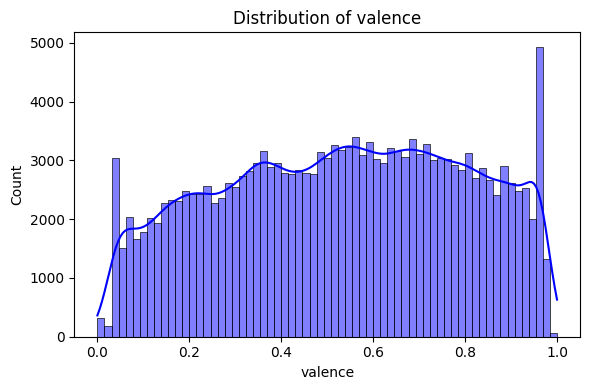

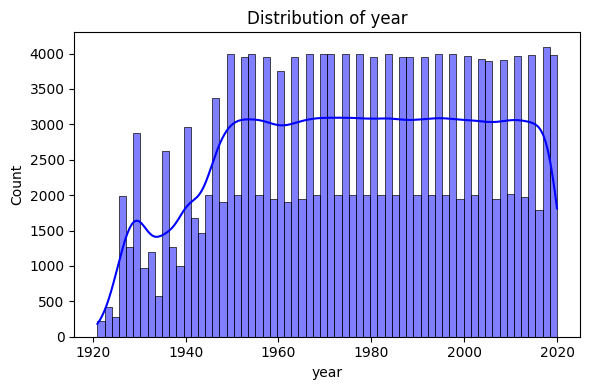

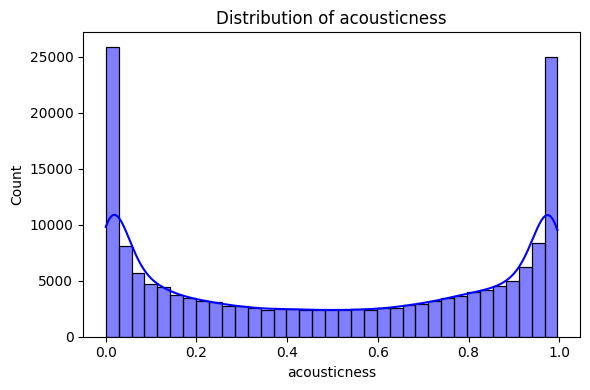

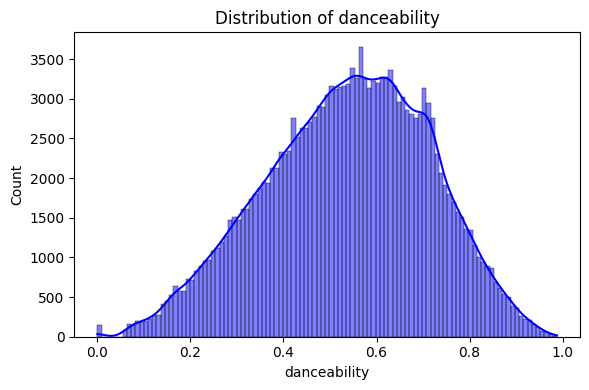

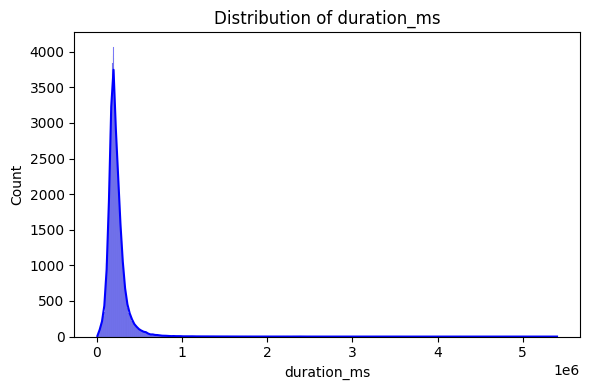

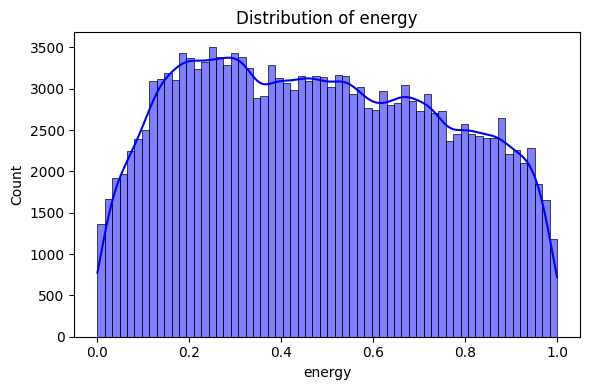

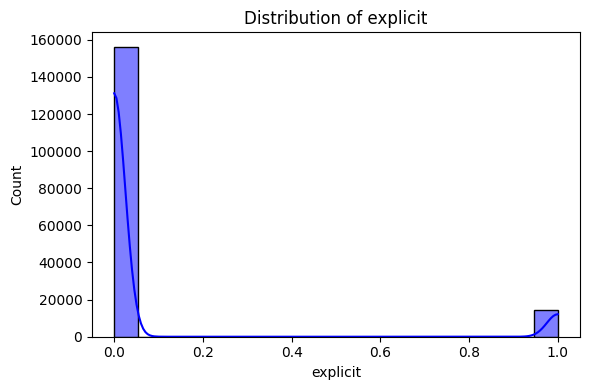

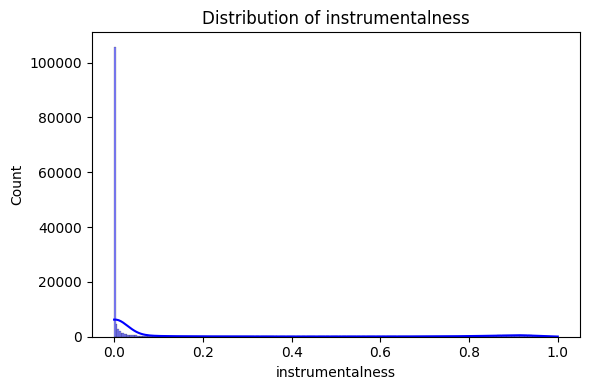

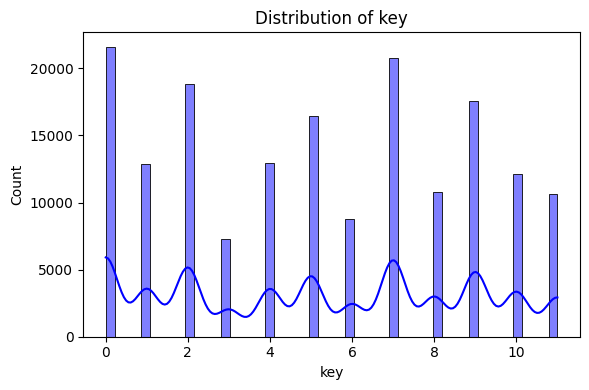

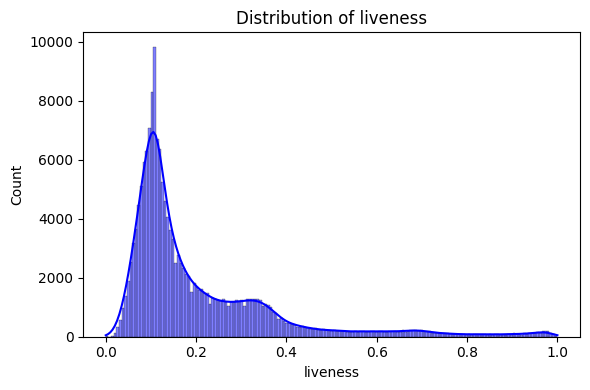

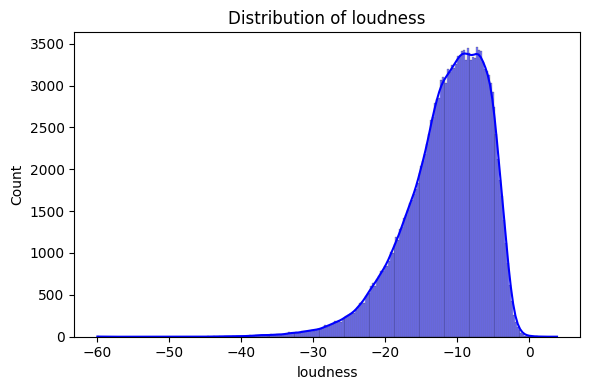

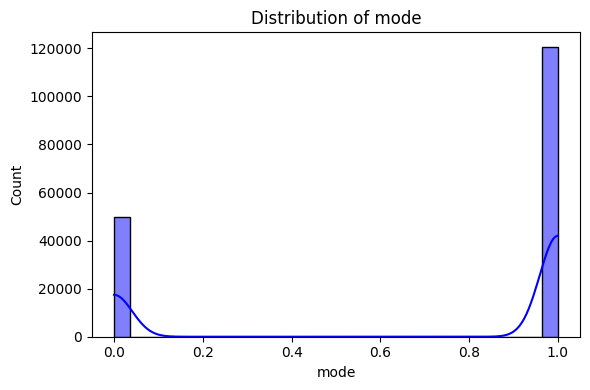

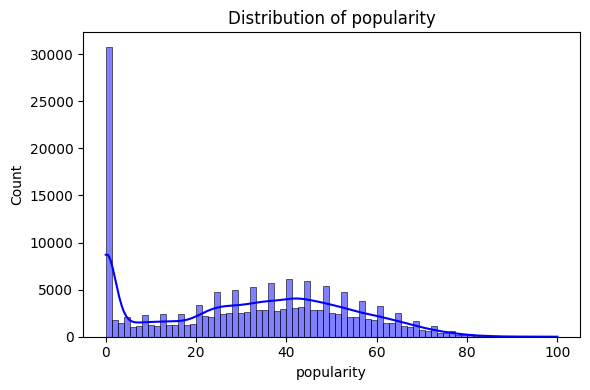

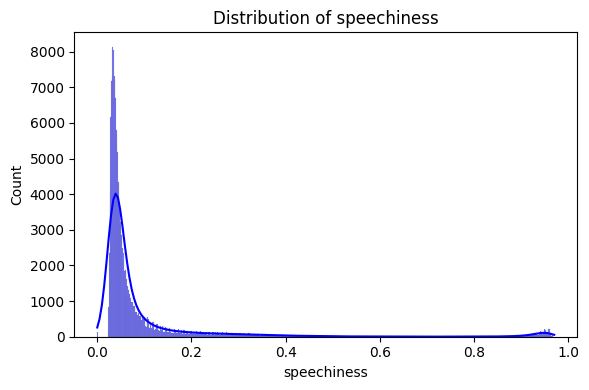

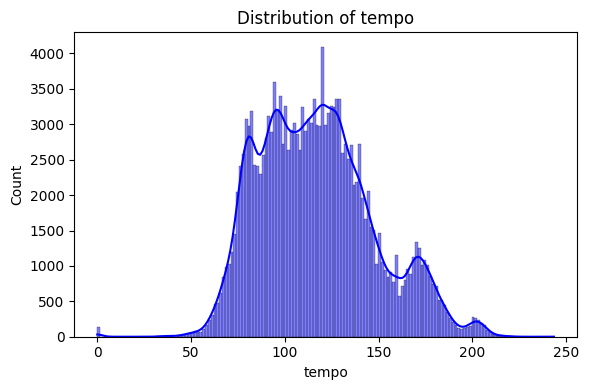


=== CORRELATION HEATMAP ===


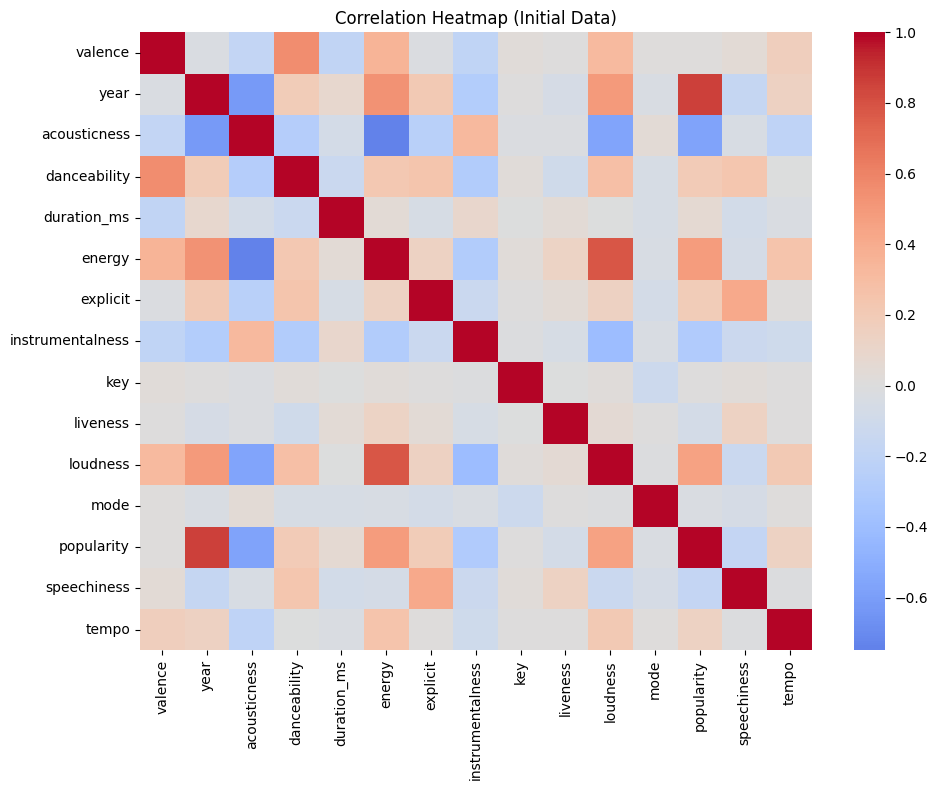


Computing outlier probability ...


In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, MinMaxScaler,
    PowerTransformer
)
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, IsolationForest
)
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.inspection import PartialDependenceDisplay

import joblib
import shap  # pip install shap
import kagglehub  # pip install kagglehub
warnings.filterwarnings('ignore')

# Native XGBRegressor (no wrapper):
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, RegressorMixin


###############################################################################
#                      HELPER: SCALER SWITCHER
###############################################################################
class ScalerSwitcher(BaseEstimator, TransformerMixin):
    """
    Switches between scaler classes (StandardScaler, RobustScaler, MinMaxScaler).
    We pass the scaler class in param, scikit-learn can clone it.
    """
    def __init__(self, scaler=StandardScaler):
        self.scaler = scaler
        self.scaler_ = None

    def fit(self, X, y=None):
        if self.scaler is not None:
            self.scaler_ = self.scaler()
            self.scaler_.fit(X)
        return self

    def transform(self, X):
        if self.scaler_ is not None:
            return self.scaler_.transform(X)
        return X

    def _more_tags(self):
        return {
            "allow_nan": True
        }

    def get_params(self, deep=True):
        return {"scaler": self.scaler}

    def set_params(self, **params):
        if "scaler" in params:
            self.scaler = params["scaler"]
        return self


###############################################################################
#           HELPER: COMPUTE OUTLIER PROBABILITY
###############################################################################
def compute_outlier_probability(X):
    """
    Combine scores from IsolationForest, OneClassSVM, LocalOutlierFactor,
    then min-max scale and average => 'outlier_prob'.
    """
    from sklearn.preprocessing import MinMaxScaler
    numeric_X = X.select_dtypes(include=[np.number]).copy()

    iso = IsolationForest(contamination=0.05, random_state=42)
    iso.fit(numeric_X)
    iso_scores = -iso.score_samples(numeric_X)

    svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
    svm.fit(numeric_X)
    svm_scores = -svm.score_samples(numeric_X)

    lof = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.05)
    lof.fit(numeric_X)
    lof_scores = -lof.score_samples(numeric_X)

    stacked = np.vstack([iso_scores, svm_scores, lof_scores]).T
    mm = MinMaxScaler()
    scaled = mm.fit_transform(stacked)
    outlier_prob = scaled.mean(axis=1)
    return outlier_prob


###############################################################################
#           Sklearn Fix bootstrap
###############################################################################
class SklearnCompatibleXGBRegressor(BaseEstimator, RegressorMixin):
    """
    A wrapper for XGBRegressor that properly implements sklearn interface
    using composition instead of inheritance.
    """
    # Explicitly set estimator type
    _estimator_type = "regressor"
    
    def __init__(self, 
                 n_estimators=100,
                 learning_rate=0.1,
                 max_depth=3,
                 random_state=42,
                 **kwargs):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.kwargs = kwargs
        
        # Create the actual XGBoost regressor
        self.model = XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state,
            **self.kwargs
        )
        
    def fit(self, X, y, **kwargs):
        """Fit the model"""
        self.model.fit(X, y, **kwargs)
        return self
        
    def predict(self, X):
        """Predict using the model"""
        return self.model.predict(X)
    
    def set_params(self, **params):
        """Set the parameters of this estimator."""
        for key, value in params.items():
            setattr(self, key, value)
        self.model = XGBRegressor(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state,
            **self.kwargs
        )
        return self
    
    def score(self, X, y, sample_weight=None):
        """Returns the coefficient of determination R^2 of the prediction."""
        from sklearn.metrics import r2_score
        y_pred = self.predict(X)
        return r2_score(y, y_pred, sample_weight=sample_weight)

    @property
    def feature_importances_(self):
        """Return feature importances from the underlying model."""
        return self.model.feature_importances_

    def __sklearn_is_fitted__(self):
        """Tell sklearn if the model is fitted."""
        # Access a property that should be set during fit
        try:
            getattr(self.model, 'feature_importances_')
            return True
        except AttributeError:
            return False

###############################################################################
#                     MAIN CLASS
###############################################################################
class SpotifyPopularityPredictor:
    def __init__(self):
        # Original numeric features
        self.numeric_features = [
            'acousticness','danceability','duration_ms','energy',
            'instrumentalness','key','liveness','loudness','mode',
            'speechiness','tempo','valence','year'
        ]
        self.pipeline_features = []
        self.best_model = None

        # For storing advanced transformations
        self.high_vif_features_ = []
        self.pca_transformer_ = None
        self.pca_feature_names_ = []

    ###########################################################################
    #                        DATA ACQUISITION
    ###########################################################################
    def download_data(self):
        if os.path.exists('data.csv'):
            print("Using existing data.csv...")
            return pd.read_csv('data.csv')
        print("Downloading dataset using kagglehub...")
        path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
        if not os.path.exists('data.csv'):
            for root, dirs, files in os.walk(path):
                if 'data.csv' in files:
                    import shutil
                    shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                    break
        if os.path.exists('data.csv'):
            print("data.csv ready.")
            return pd.read_csv('data.csv')
        else:
            raise FileNotFoundError("data.csv not found after kagglehub download.")

    ###########################################################################
    #         BASIC STATS & FUNDAMENTAL EDA
    ###########################################################################
    def basic_eda(self, df):
        """
        Perform fundamental Exploratory Data Analysis:
         1. Basic stats (mean, median, std, etc.)
         2. Distribution plots for numeric columns
         3. Correlation heatmap
        """
        print("\n=== BASIC STATISTICS ===")
        stats = df.describe(include='all')
        print(stats)

        numeric_cols = df.select_dtypes(include=[np.number]).columns
        print("\n=== HISTOGRAMS FOR NUMERIC COLUMNS ===")
        for col in numeric_cols:
            plt.figure(figsize=(6,4))
            sns.histplot(df[col].dropna(), kde=True, color='blue')
            plt.title(f"Distribution of {col}")
            plt.tight_layout()
            plt.show()

        print("\n=== CORRELATION HEATMAP ===")
        corr_ = df[numeric_cols].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr_, annot=False, cmap='coolwarm', center=0)
        plt.title("Correlation Heatmap (Initial Data)")
        plt.tight_layout()
        plt.show()

    ###########################################################################
    #                   PREPARE FEATURES
    ###########################################################################
    def normalize_year_feature(self, df):
        df = df.copy()
        miny, maxy = df['year'].min(), df['year'].max()
        df['years_since_first'] = (df['year'] - miny)/(maxy - miny)
        df['decade'] = ((df['year']-miny)//10)*10/(maxy - miny)
        df.drop('year', axis=1, inplace=True)
        return df

    def add_noise_feature(self, df, noise_level=0.01):
        np.random.seed(42)
        noise = np.random.normal(0, noise_level, size=len(df))
        df['noise'] = noise
        return df

    def prepare_features(self, df):
        df_ = df.copy()
        if 'year' in df_.columns:
            df_ = self.normalize_year_feature(df_)

        if 'key' in df_.columns:
            df_['key_sin'] = np.sin(2*np.pi*df_['key']/12)
            df_['key_cos'] = np.cos(2*np.pi*df_['key']/12)
            df_.drop('key', axis=1, inplace=True)

        if 'artists' in df_.columns:
            df_['artist_count'] = df_['artists'].str.count(',') + 1
            df_.drop('artists', axis=1, inplace=True)

        df_ = self.add_noise_feature(df_)
        return df_

    def add_outlier_feature(self, X):
        print("\nComputing outlier probability ...")
        prob = compute_outlier_probability(X)
        X_ = X.copy()
        X_['outlier_prob'] = prob
        print("Outlier prob added to data.")
        return X_

    ###########################################################################
    #                  VIF & PCA FOR MULTICOLLINEARITY
    ###########################################################################
    def handle_multicollinearity(self, X, threshold=5, max_iter=10):
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        from scipy import stats
        from sklearn.preprocessing import PowerTransformer

        def calc_vif(df_):
            arr = df_.values
            result = []
            for i in range(arr.shape[1]):
                try:
                    result.append(variance_inflation_factor(arr, i))
                except:
                    result.append(np.inf)
            return pd.DataFrame({"Feature": df_.columns,"VIF": result}).sort_values("VIF", ascending=False)

        def transform_feat(df_, feat):
            original = df_[feat].copy()
            for method in ["log","sqrt","boxcox","yeo-johnson"]:
                try:
                    if method=="log" and (df_[feat]>0).all():
                        df_[feat] = np.log1p(df_[feat])
                        return True, method
                    elif method=="sqrt" and (df_[feat]>=0).all():
                        df_[feat] = np.sqrt(df_[feat]-df_[feat].min() + 1e-6)
                        return True, method
                    elif method=="boxcox" and (df_[feat]>0).all():
                        bc, _ = stats.boxcox(df_[feat])
                        df_[feat]=bc
                        return True, method
                    elif method=="yeo-johnson":
                        pt = PowerTransformer(method='yeo-johnson')
                        df_[feat] = pt.fit_transform(df_[feat].values.reshape(-1,1)).ravel()
                        return True, method
                except:
                    pass
            df_[feat] = original
            return False, None

        X_ = X.copy()
        for i in range(max_iter):
            vif_data = calc_vif(X_)
            maxvif = vif_data['VIF'].max()
            if maxvif <= threshold:
                print(f"All VIF <= {threshold}, stopping transformations.")
                break
            top_feat = vif_data.iloc[0]['Feature']
            print(f"\nIteration {i+1}: Highest VIF => {maxvif:.2f} at '{top_feat}'")
            success, method = transform_feat(X_, top_feat)
            if success:
                print(f"  => Transformed '{top_feat}' with {method}.")
            else:
                print(f"  => Could not transform '{top_feat}'. Will do PCA.")
                self.high_vif_features_.append(top_feat)
                break

        # PCA step
        final_vif = calc_vif(X_)
        high_vif_feats = final_vif[final_vif['VIF']>threshold]['Feature'].tolist()
        if high_vif_feats:
            print("\nApplying PCA to high-VIF features:", high_vif_feats)
            from sklearn.preprocessing import StandardScaler
            sc = StandardScaler()
            Xh = X_[high_vif_feats].copy()
            Xl = X_.drop(columns=high_vif_feats)

            Xh_scaled = sc.fit_transform(Xh)
            pca = PCA(n_components=0.95, random_state=42)
            Xpca = pca.fit_transform(Xh_scaled)
            pca_cols = [f'PCA_{i+1}' for i in range(Xpca.shape[1])]
            xpca_df = pd.DataFrame(Xpca, columns=pca_cols, index=X_.index)

            X_ = pd.concat([Xl, xpca_df], axis=1)
            self.high_vif_features_ = high_vif_feats
            self.pca_transformer_ = pca
            self.pca_feature_names_ = pca_cols

            check_vif = calc_vif(X_)
            print("\nVIF after PCA:")
            print(check_vif)
        else:
            print("\nNo PCA needed => VIF is below threshold.")

        return X_

    ###########################################################################
    #                 CREATE ENSEMBLE
    ###########################################################################
    def create_ensemble_regressor(self):
        base_ests = [
            ('ridge', Ridge(alpha=1.0)),
            ('lasso', Lasso(alpha=0.01)),
            ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
            ('gb1', GradientBoostingRegressor(n_estimators=50, random_state=42))
        ]
        
        final_est = GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        )
        
        model = StackingRegressor(
            estimators=base_ests,
            final_estimator=final_est,
            passthrough=False,
            cv=3,
            n_jobs=-1
        )
        return model

    ###########################################################################
    #               CREATE PIPELINE & RANDOM SEARCH
    ###########################################################################
    def create_preprocessing_pipeline(self):
        from sklearn.pipeline import Pipeline

        numeric_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', ScalerSwitcher()),
            ('power', PowerTransformer(method='yeo-johnson'))
        ])
        preprocessor = ColumnTransformer([
            ('num', numeric_transformer, self.pipeline_features)
        ])
        return preprocessor

    def create_model_pipeline(self, preprocessor):
        from sklearn.pipeline import Pipeline

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('feature_selection', SelectKBest(score_func=f_regression, k='all')),
            ('regressor', self.create_ensemble_regressor())
        ])

        param_distributions = {
            'preprocessor__num__imputer__strategy': ['mean', 'median'],
            'preprocessor__num__scaler__scaler': [StandardScaler, RobustScaler, MinMaxScaler],
            'preprocessor__num__power__method': ['yeo-johnson'],
            'feature_selection__k': [8, 10, 'all'],

            'regressor__rf__n_estimators': [50, 100, 200],
            'regressor__rf__max_depth': [None, 5, 10, 20],

            'regressor__gb1__n_estimators': [50, 100, 200],
            'regressor__gb1__learning_rate': [0.05, 0.1, 0.2],
            'regressor__gb1__max_depth': [3, 5, 7],

            'regressor__final_estimator__n_estimators': [50, 100, 200],
            'regressor__final_estimator__learning_rate': [0.01, 0.05, 0.1],
            'regressor__final_estimator__max_depth': [3, 5, 7]
        }
        return pipeline, param_distributions

    def train_model(self, X, y):
        from sklearn.model_selection import RandomizedSearchCV
        pipe, param_distr = self.create_model_pipeline(self.create_preprocessing_pipeline())

        rnd_search = RandomizedSearchCV(
            pipe,
            param_distributions=param_distr,
            n_iter=50,
            cv=3,
            scoring='r2',
            random_state=42,
            n_jobs=-1,
            verbose=2,
            error_score='raise'
        )
        print("Running RandomizedSearchCV now ...")
        rnd_search.fit(X, y)
        self.best_model = rnd_search
        print("\nBest Params:", rnd_search.best_params_)
        print(f"Best CV R2: {rnd_search.best_score_:.4f}")
        return rnd_search

    ###########################################################################
    #                    MULTIPLE METRICS
    ###########################################################################
    def compute_metrics(self, y_true, y_pred):
        """
        Return multiple metrics: R², MSE, RMSE, MAE, MAPE, MedianAE
        """
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))

        # MAPE => handle any zeros carefully
        mask = (y_true != 0)
        if mask.sum() > 0:
            mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        else:
            mape = np.nan

        median_ae = median_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        metrics_dict = {
            "r2": r2,
            "mse": mse,
            "rmse": rmse,
            "mae": mae,
            "mape%": mape,
            "medianAE": median_ae
        }
        return metrics_dict

    ###########################################################################
    #                   DIAGNOSTICS & VISUAL
    ###########################################################################
    def plot_diagnostics(self, y_test, y_pred, metrics):
        resid = y_test - y_pred

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22,5))

        ax1.scatter(y_test, y_pred, alpha=0.5)
        ax1.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()],'r--')
        ax1.set_title(f"Actual vs Pred (R2={metrics['r2']:.3f})")

        ax2.scatter(y_pred, resid, alpha=0.5)
        ax2.axhline(y=0, color='r', lw=2)
        ax2.set_title("Resid vs Pred")

        ax3.hist(resid, bins=50, color='orange')
        ax3.set_title("Resid Dist")

        probplot(resid, plot=ax4)
        ax4.set_title("Q-Q Plot")

        plt.tight_layout()
        plt.show()

    def plot_feature_correlations(self, X):
        corr_ = X.corr()
        plt.figure(figsize=(12,10))
        sns.heatmap(corr_, annot=False, cmap='coolwarm', center=0)
        plt.title("Feature Correlation (Post-VIF/PCA)")
        plt.tight_layout()
        plt.show()

    def partial_dependence_plots(self, model, X, feats_idx):
        if not feats_idx:
            print("No valid features for partial dependence.")
            return
        print("\nPlot partial dependence for selected features ...")
        fig, ax = plt.subplots(figsize=(12,8))
        PartialDependenceDisplay.from_estimator(model, X, features=feats_idx, ax=ax, kind='average')
        plt.tight_layout()
        plt.show()

    def shap_summary_plot(self, model, X):
        print("\nSHAP Summary ...")
        try:
            n = 1000 if len(X) > 1000 else len(X)
            Xsam = X.sample(n, random_state=42)
            explainer = shap.Explainer(model.predict, Xsam)
            shap_values = explainer(Xsam)
            shap.summary_plot(shap_values, Xsam, plot_type="bar")
            shap.summary_plot(shap_values, Xsam)
        except Exception as e:
            print("SHAP error:", e)

    def plot_absolute_contributions(self, X, model):
        final_ = model.best_estimator_.named_steps['regressor']
        if not hasattr(final_, 'named_estimators_'):
            print("No named_estimators_ => skip absolute contributions.")
            return

        if self.pca_transformer_:
            print("PCA used => skip linear sub-model contributions.")
            return

        coefs = []
        feats = self.pipeline_features
        if 'ridge' in final_.named_estimators_:
            c = final_.named_estimators_['ridge'].coef_
            coefs.append(np.abs(c))
        if 'lasso' in final_.named_estimators_:
            c = final_.named_estimators_['lasso'].coef_
            coefs.append(np.abs(c))

        if coefs:
            avg_c = np.mean(coefs, axis=0)
            df_ = pd.DataFrame({'feature': feats, 'abs_coef': avg_c})
            df_ = df_.sort_values('abs_coef', ascending=False)
            plt.figure(figsize=(10,6))
            sns.barplot(x='abs_coef', y='feature', data=df_, palette='viridis')
            plt.title("Absolute Coefficients (Linear Sub-models)")
            plt.tight_layout()
            plt.show()
        else:
            print("No linear coefs => skip absolute contributions.")

    ###########################################################################
    #                       MODEL PERSISTENCE
    ###########################################################################
    def save_model(self, filename='spotify_popularity_model.joblib'):
        if self.best_model:
            joblib.dump(self.best_model, filename)
            print(f"Model saved as '{filename}'")
        else:
            print("No model => skipping save.")

    def load_model(self, filename='spotify_popularity_model.joblib'):
        if os.path.exists(filename):
            self.best_model = joblib.load(filename)
            print(f"Model loaded from '{filename}'")
            return self.best_model
        else:
            print("No saved model found at:", filename)
            return None

    ###########################################################################
    #                          MAIN ENTRY
    ###########################################################################
    def run_analysis(self):
        model_fname = "spotify_popularity_model.joblib"
        if os.path.exists(model_fname):
            print(f"Found existing model => loading from '{model_fname}'...")
            loaded = self.load_model(model_fname)
            if loaded:
                print("Model loaded => skipping training.")
                return
            else:
                print("Could not load => will train a new model.")
        else:
            print("No existing model => training new one.")

        # 1. Download data
        df = self.download_data()

        # 2. Basic EDA => optional
        self.basic_eda(df)

        # 3. Prepare features
        Xprep = self.prepare_features(df[self.numeric_features])
        y = df['popularity'].values

        # 4. Outlier
        Xout = self.add_outlier_feature(Xprep)

        # 5. VIF + PCA
        Xfin = self.handle_multicollinearity(Xout, threshold=5, max_iter=10)
        self.pipeline_features = list(Xfin.columns)
        print("\nFinal feature set:", self.pipeline_features)

        # 6. Split
        X_tr, X_te, y_tr, y_te = train_test_split(Xfin, y, test_size=0.2, random_state=42)
        print(f"Train size: {len(y_tr)}, Test size: {len(y_te)}")

        # 7. Train
        print("\nRunning RandomizedSearchCV now ...")
        try:
            model = self.train_model(X_tr, y_tr)
        except Exception as e:
            print("Training failed =>", e)
            return

        # 8. Evaluate => multiple metrics
        y_pred = model.predict(X_te)
        metrics_ = self.compute_metrics(y_te, y_pred)
        print("\n--- TEST METRICS ---")
        for k,v in metrics_.items():
            print(f"{k}: {v:.4f}")

        # 9. Diagnostics
        self.plot_diagnostics(y_te, y_pred, metrics_)
        self.plot_feature_correlations(Xfin)

        # 10. partial dependence
        feats_interest = []
        for f_ in ['outlier_prob','energy']:
            if f_ in self.pipeline_features:
                feats_interest.append(self.pipeline_features.index(f_))
        if feats_interest:
            self.partial_dependence_plots(model.best_estimator_, X_te, feats_interest)

        # 11. SHAP
        try:
            self.shap_summary_plot(model.best_estimator_, X_te)
        except Exception as ex:
            print("SHAP error =>", ex)

        # 12. Absolute contributions
        self.plot_absolute_contributions(X_te, model)

        # 13. Save model
        self.save_model(model_fname)


###############################################################################
#                           USAGE
###############################################################################
if __name__=="__main__":
    predictor = SpotifyPopularityPredictor()
    predictor.run_analysis()


### Data Exploration

In [8]:
print(df.head())

   valence  year  acousticness  \
0   0.0594  1921         0.982   
1   0.9630  1921         0.732   
2   0.0394  1921         0.961   
3   0.1650  1921         0.967   
4   0.2530  1921         0.957   

                                             artists  danceability  \
0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...         0.279   
1                                     ['Dennis Day']         0.819   
2  ['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...         0.328   
3                                   ['Frank Parker']         0.275   
4                                     ['Phil Regan']         0.418   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       831667   0.211         0  4BJqT0PrAfrxzMOxytFOIz          0.878000   
1       180533   0.341         0  7xPhfUan2yNtyFG0cUWkt8          0.000000   
2       500062   0.166         0  1o6I8BglA6ylDMrIELygv1          0.913000   
3       210000   0.309         0  3ftBPsC5vPBKxYSee08FDH      

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [10]:
print(df.describe())

             valence           year   acousticness   danceability  \
count  170653.000000  170653.000000  170653.000000  170653.000000   
mean        0.528587    1976.787241       0.502115       0.537396   
std         0.263171      25.917853       0.376032       0.176138   
min         0.000000    1921.000000       0.000000       0.000000   
25%         0.317000    1956.000000       0.102000       0.415000   
50%         0.540000    1977.000000       0.516000       0.548000   
75%         0.747000    1999.000000       0.893000       0.668000   
max         1.000000    2020.000000       0.996000       0.988000   

        duration_ms         energy       explicit  instrumentalness  \
count  1.706530e+05  170653.000000  170653.000000     170653.000000   
mean   2.309483e+05       0.482389       0.084575          0.167010   
std    1.261184e+05       0.267646       0.278249          0.313475   
min    5.108000e+03       0.000000       0.000000          0.000000   
25%    1.698270e+05    

In [11]:
print(df.isnull().sum())

valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
numeric_cols = df.select_dtypes(include=[np.number]).columns

In [24]:
df.iloc[:,0:3]

valence  year  acousticness
0        0.0594  1921       0.98200
1        0.9630  1921       0.73200
2        0.0394  1921       0.96100
3        0.1650  1921       0.96700
4        0.2530  1921       0.95700
...         ...   ...           ...
170648   0.6080  2020       0.08460
170649   0.7340  2020       0.20600
170650   0.6370  2020       0.10100
170651   0.1950  2020       0.00998
170652   0.6420  2020       0.13200

[170653 rows x 3 columns]

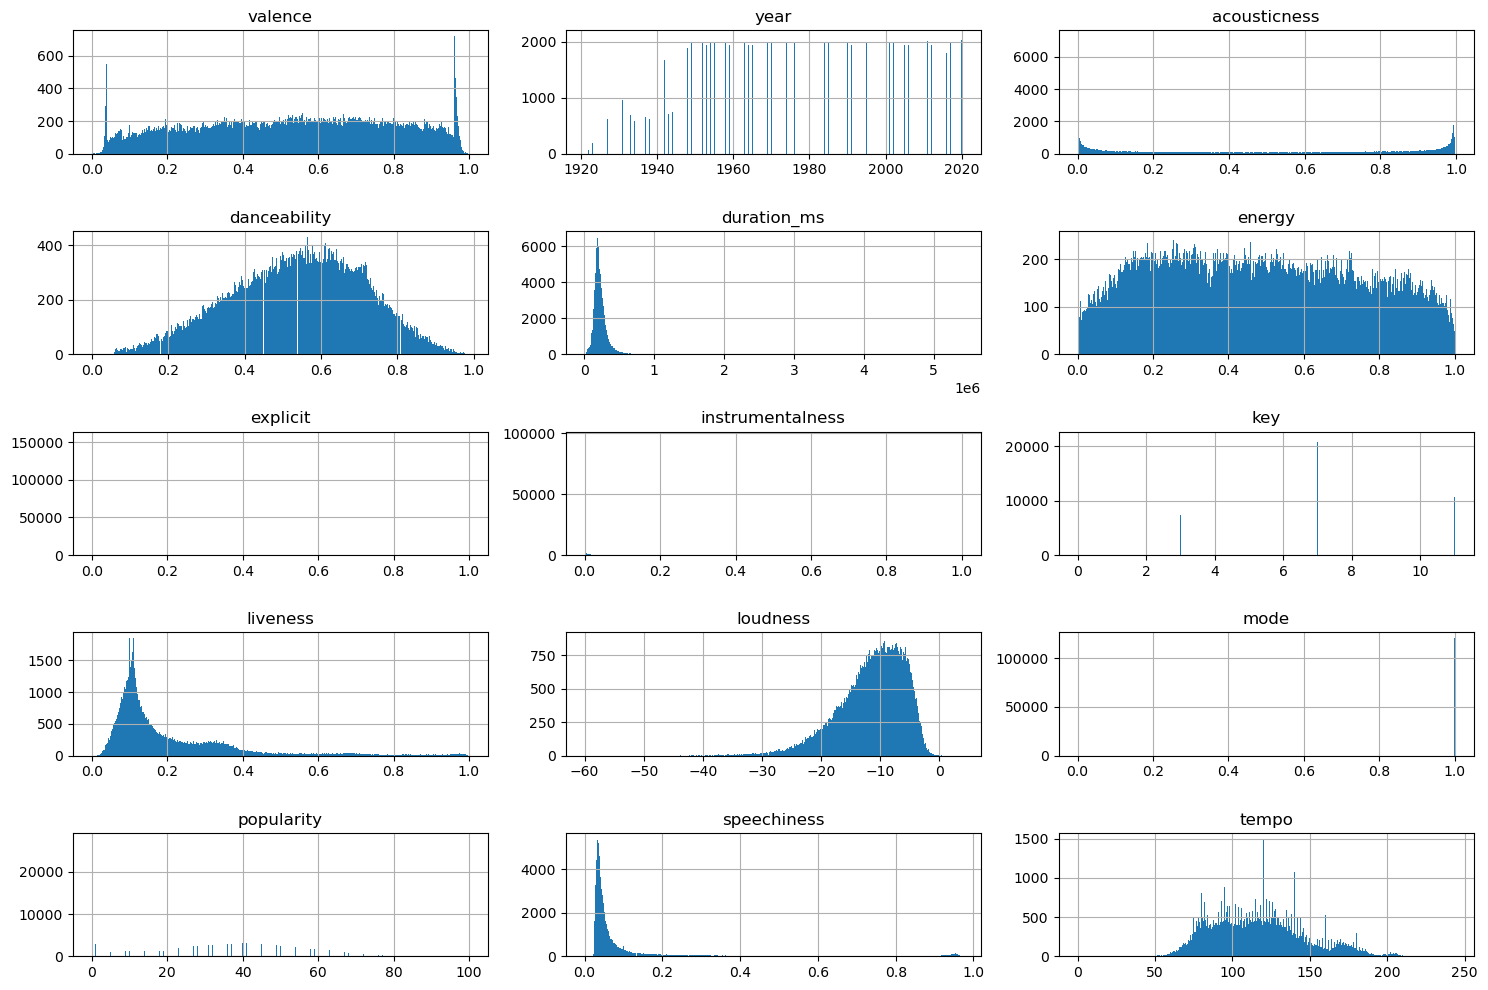

In [19]:
df[numeric_cols].hist(bins=999, figsize=(15,10), layout=(5,3))
plt.tight_layout()
plt.show()

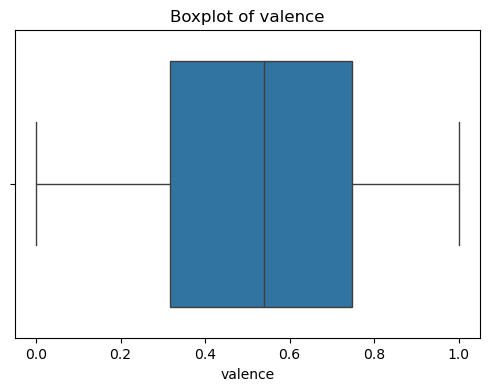

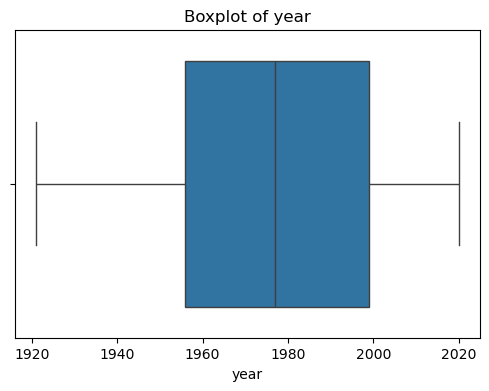

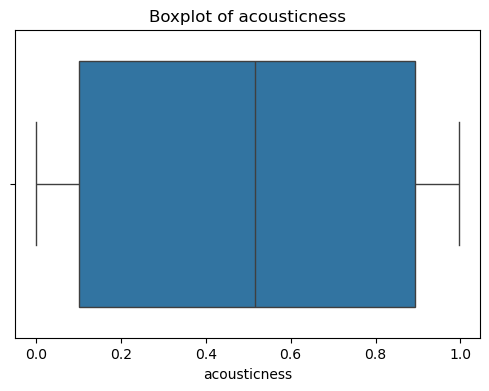

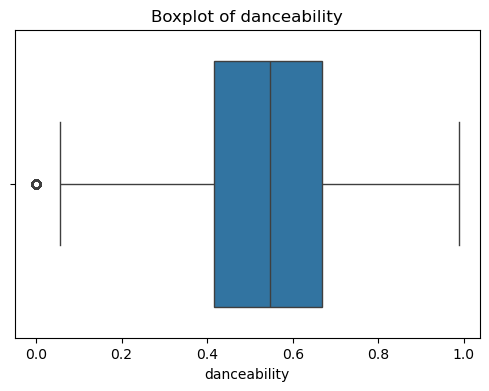

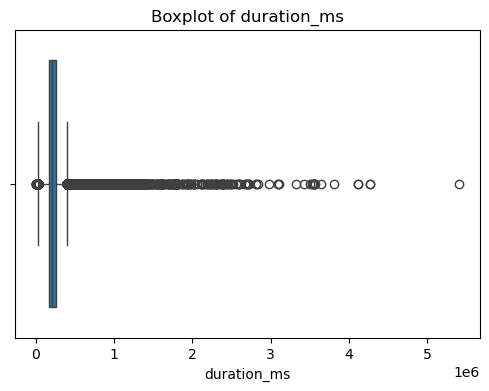

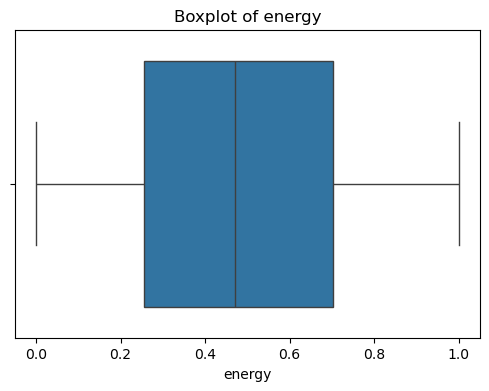

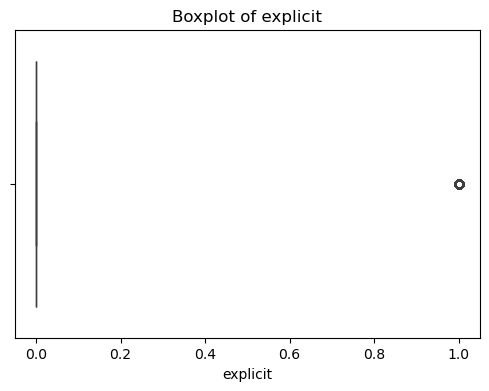

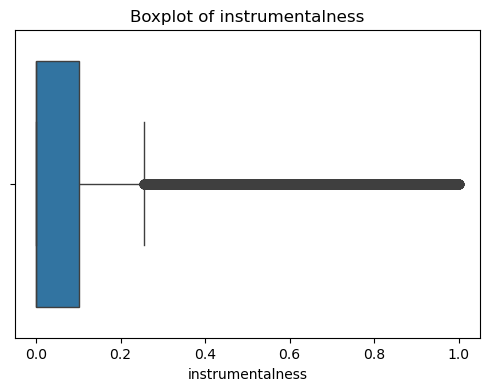

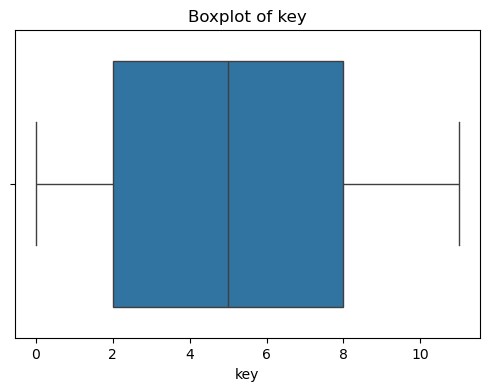

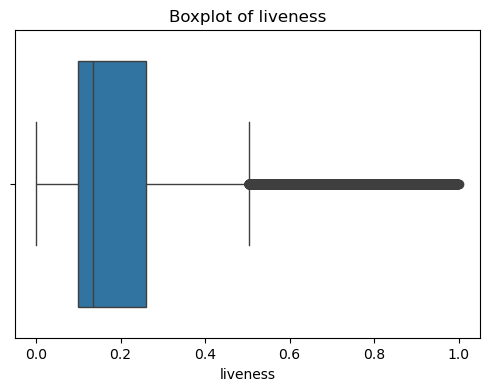

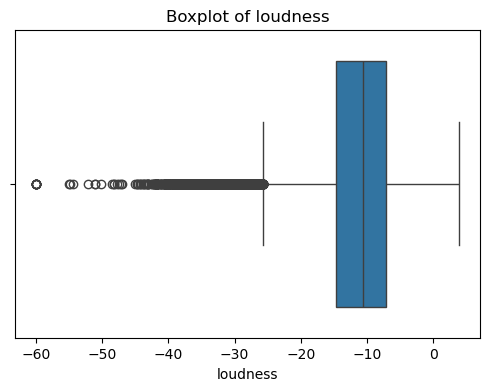

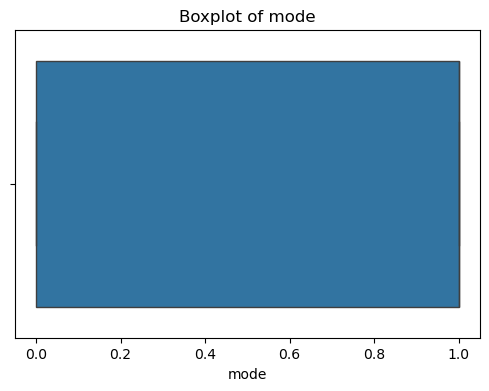

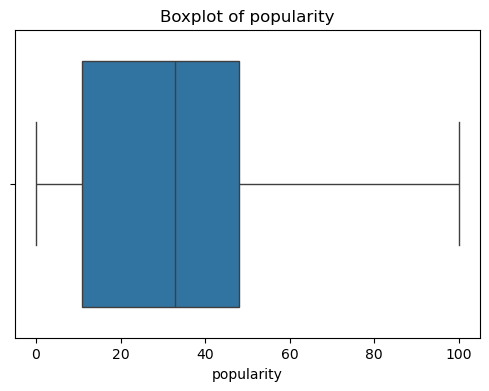

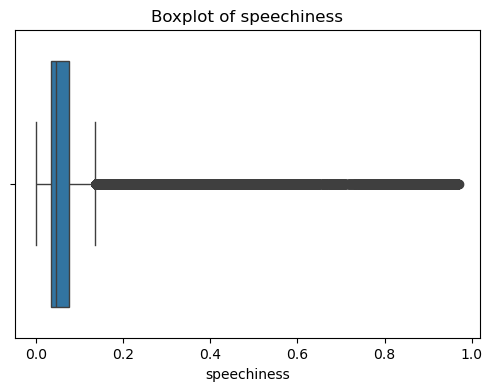

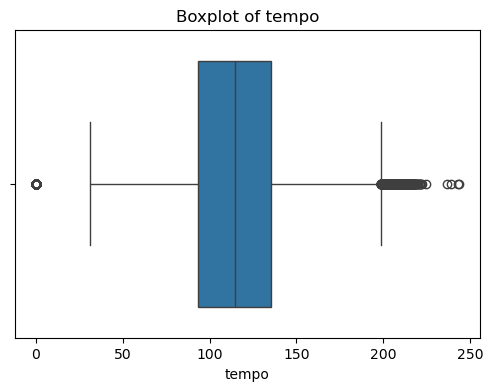

In [17]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()